In [46]:
import os
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.preprocess import remove_urls, strip_html
from reviews.config import processed_data_dir
from reviews.utils import clean_brand

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Data Cleaning

## Products

In [47]:
prod_df = pd.read_json(processed_data_dir / "meta.json.gz")
prod_df = prod_df.reindex(sorted(prod_df.columns), axis=1)  # sort columns
prod_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32720 entries, 0 to 32719
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   asin             32720 non-null  object
 1   brand            32720 non-null  object
 2   category         32720 non-null  object
 3   description      32720 non-null  object
 4   imageURLHighRes  32720 non-null  object
 5   price            32720 non-null  object
 6   title            32720 non-null  object
dtypes: object(7)
memory usage: 1.7+ MB


In [48]:
prod_df.head(10)

,asin,brand,category,description,imageURLHighRes,price,title
0,7500653883,ECS Elitegroup,"[Electronics, Computers & Accessories, Compute...",[],[],,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,MyGica,"[Electronics, Computers & Accessories, Compute...","[Mygica EZgrabber2 USB 2.0 Video Capture, VHS ...",[https://images-na.ssl-images-amazon.com/image...,,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,Creative,"[Electronics, Computers & Accessories, Compute...",[],[],,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,APC,"[Electronics, Computers & Accessories, Compute...",[APC 650 VA Uninterruptable Power Supply],[],,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],[],,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,Creative,"[Electronics, Computers & Accessories, Compute...",[Based on the award-winning Sound Blaster 16 t...,[],$2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,Creative,"[Electronics, Computers & Accessories, Compute...",[Unleash incredible graphics performance!],[],,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,Diamond,"[Electronics, Computers & Accessories, Compute...",[Monster Sound MX300 is the new-generation PCI...,[],,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,SONICblue,"[Electronics, Computers & Accessories, Compute...","[Based on the NVIDIA RIVA TNT Ultra chip set, ...",[https://images-na.ssl-images-amazon.com/image...,,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,PNY,"[Electronics, Computers & Accessories, Compute...",[Adding memory to your new or existing desktop...,[],,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Transform Data

In [49]:
# keep the first subcategory and rename categories
prod_df["category"] = prod_df["category"].parallel_apply(
    lambda x: x[4] if len(x) > 4 else "other"
)

prod_df["category"] = prod_df["category"].apply(
    lambda cat: cat.replace("Internal", "").strip() if type(cat) is str else cat
)

# join description in a single string
prod_df["description"] = prod_df["description"].parallel_apply(lambda x: " ".join(x))

# remove html and replace empty with NA
for col in ["category", "description", "title", "brand", "asin"]:
    prod_df[col] = prod_df[col].astype("string").parallel_apply(strip_html)
    prod_df.loc[prod_df[col] == "", col] = np.nan

# fix price
prod_df["price"] = prod_df["price"].astype("string").parallel_apply(strip_html)
prod_df["price"] = prod_df["price"].str.replace("[\$,]", "", regex=True)
prod_df.loc[prod_df["price"].str.len() == 0, "price"] = np.nan
prod_df.loc[prod_df["price"].str.len() > 8, "price"] = np.nan

prod_df["brand"] = prod_df["brand"].apply(clean_brand)

prod_df["imageURLHighRes"] = prod_df["imageURLHighRes"].parallel_apply(
    lambda x: x[0] if x else np.nan
)

In [50]:
prod_df.head(10)

,asin,brand,category,description,imageURLHighRes,price,title
0,7500653883,ecs elitegroup,Motherboards,NaN,NaN,NaN,ECS PT800CE-A Socket 478 Motherboard Prescott ...
1,7799813393,mygica,TV Tuner & Capture Cards,"Mygica EZgrabber2 USB 2.0 Video Capture, VHS t...",https://images-na.ssl-images-amazon.com/images...,NaN,"Mygica EZgrabber USB 2.0 Video Capture, VHS to..."
2,B00000J3OG,creative,Modems,NaN,NaN,NaN,Creative Labs DI5601 Modem Blaster 56K Interna...
3,B00000J3WY,apc,Power Supplies,APC 650 VA Uninterruptable Power Supply,NaN,NaN,APC 650VA Back-Up Power Supply (Discontinued b...
4,B00000J576,creative,Graphics Cards,Unleash incredible graphics performance!,NaN,NaN,Creative Labs 3DB6815BULK 3D Blaster Savage4 P...
5,B00000J579,creative,Sound Cards,Based on the award-winning Sound Blaster 16 te...,NaN,2.05,Creative Labs Sound Blaster 16 PCI Sound Card
6,B00000J571,creative,Graphics Cards,Unleash incredible graphics performance!,NaN,NaN,Creative Labs 3DB6901 3D Blaster Savage4 AGP 32
7,B00000JBB8,diamond,Graphics Cards,Monster Sound MX300 is the new-generation PCI ...,NaN,NaN,Diamond MX300 MonsterSound PCI Audio Accelerat...
8,B00000JBBJ,sonicblue,Graphics Cards,"Based on the NVIDIA RIVA TNT Ultra chip set, D...",https://images-na.ssl-images-amazon.com/images...,NaN,Diamond Viper V770 Ultra Graphics Accelerator
9,B00000JBJ8,pny,Memory,Adding memory to your new or existing desktop ...,NaN,NaN,PNY 64174ESEM4G-CS 128MB 168 Pin DIMM SDRAM PC...


### Convert Data Types

In [51]:
prod_df["asin"] = prod_df["asin"].astype("string")
prod_df["brand"] = prod_df["brand"].astype("category")
prod_df["category"] = prod_df["category"].astype("category")
prod_df["description"] = prod_df["description"].astype("string")
prod_df["price"] = prod_df["price"].astype("float")
prod_df["title"] = prod_df["title"].astype("string")
prod_df["imageURLHighRes"] = prod_df["imageURLHighRes"].astype("string")

In [52]:
prod_df.to_json(processed_data_dir / "products_cleaned.json.gz")

## Reviews

In [53]:
review_df = pd.read_json(processed_data_dir / "reviews.json.gz")
review_df = review_df.reindex(sorted(review_df.columns), axis=1)  # sort columns
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269029 entries, 0 to 269028
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   asin        269029 non-null  object        
 1   overall     269029 non-null  int64         
 2   reviewerID  269029 non-null  object        
 3   summary     269029 non-null  object        
 4   text        269029 non-null  object        
 5   timestamp   269029 non-null  datetime64[ns]
 6   vote        269029 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 14.4+ MB


In [54]:
review_df.head(10)

,asin,overall,reviewerID,summary,text,timestamp,vote
0,7799813393,3,A13R0XX727WQB8,Good for what it can do.,Bought this to transfer video from some old eq...,2013-01-17,0
1,7799813393,4,A2D1N6Z7WS9AQQ,works well,The EZGrabber2 works well but it's software is...,2012-09-04,0
2,7799813393,4,A3BOQADZVJB6C3,Cheap and it works,I got this because it was pretty decently pric...,2012-08-27,6
3,B00000J579,5,A1NVD0TKNS1GT5,"Easy to Use, Almost everything you could want",This sound card doesn't reproduce MP3 or WAV f...,2000-10-10,32
4,B00000J579,3,A3CCYAQRHUTPIQ,Bathtub,"Essentially, this is the entry-level, 16-bit a...",2000-09-04,4
5,B00000J579,4,A7RJ19XG5PDRU,"Good low-end, no-hassle card",This is a basic sound card. Nothing fancy. T...,2002-07-03,6
6,B00000J579,3,AT4AV7XIQDKQP,Ok for the price and basic functions,This is a basic low-end sound card. It puts ou...,2002-04-04,8
7,B00000JDKU,4,ANLA598UNJI8A,good card,The Voodoo 3 is a great card that replaces bot...,1999-11-21,18
8,B00000JDKU,5,A7RV1KU5O0II9,WOW!,This card is so fast and really high resolutio...,1999-07-15,4
9,B00000JF4L,5,A2M7NKO97UIVAH,An excellent card,Let me first state that I purchased this card ...,2000-03-15,38


In [55]:
# remove html and replace empty with NA
for col in ["asin", "overall", "summary", "text", "timestamp", "vote", "reviewerID"]:
    review_df[col] = review_df[col].astype("string").parallel_apply(strip_html)
    review_df.loc[review_df[col] == "", col] = np.nan

### Convert Data Types

In [56]:
review_df["asin"] = review_df["asin"].astype("category")
review_df["overall"] = review_df["overall"].astype("category")
review_df["summary"] = review_df["summary"].astype("string")
review_df["text"] = review_df["text"].astype("string")
review_df["timestamp"] = pd.to_datetime(review_df["timestamp"], errors="coerce")
review_df["vote"] = review_df["vote"].astype("int")
review_df["reviewerID"] = review_df["reviewerID"].astype("string")

In [57]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269029 entries, 0 to 269028
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   asin        269029 non-null  category      
 1   overall     269029 non-null  category      
 2   reviewerID  269029 non-null  string        
 3   summary     269029 non-null  string        
 4   text        269027 non-null  string        
 5   timestamp   269029 non-null  datetime64[ns]
 6   vote        269029 non-null  int64         
dtypes: category(2), datetime64[ns](1), int64(1), string(3)
memory usage: 11.3 MB


### Merge with Products

In [58]:
data_df = pd.merge(left=review_df, right=prod_df, on="asin", copy=False)

gt = data_df[data_df["overall"] != 3]["overall"].astype(int)
gt = gt.apply(lambda x: "negative" if x < 3 else "positive").astype("category")
print(gt.value_counts())

data_df = data_df.sample(30000, random_state=10)

data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["asin"] = data_df["asin"].astype("string").astype("category")
data_df["overall"] = data_df["overall"].astype("string").astype("category")
data_df["brand"] = data_df["brand"].astype("string").astype("category")
data_df["category"] = data_df["category"].astype("string").astype("category")

data_df.info()

positive    246867
negative     22162
Name: overall, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 5953 to 163538
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             30000 non-null  category      
 1   overall          30000 non-null  category      
 2   reviewerID       30000 non-null  string        
 3   summary          30000 non-null  string        
 4   text             30000 non-null  string        
 5   timestamp        30000 non-null  datetime64[ns]
 6   vote             30000 non-null  int64         
 7   brand            30000 non-null  category      
 8   category         30000 non-null  category      
 9   description      29132 non-null  string        
 10  imageURLHighRes  24849 non-null  string        
 11  price            19514 non-null  float64       
 12  title            30000 non-null  string        
dtypes: category(4), datet

In [59]:
duplicates = data_df.duplicated(["asin", "text", "summary", "overall"], keep=False)
print(f"Duplicates: {duplicates.sum()}")

data_df.drop_duplicates(["asin", "text", "summary", "overall"], inplace=True)

Duplicates: 67


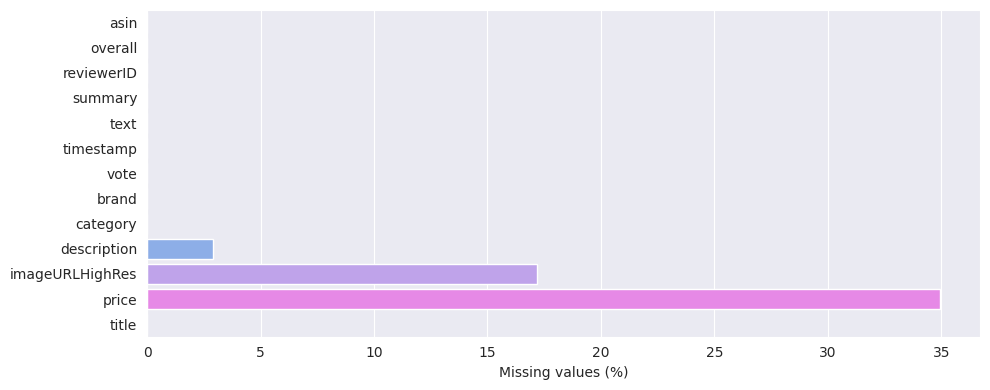

In [60]:
fig, axes = plt.subplots(1, 1, figsize=(10, 4))
#sns.heatmap(data_df.isna().T, cbar=False, xticklabels=False, ax=axes[0])
sns.barplot(
    y=data_df.columns,
    x=(len(data_df) - data_df.count()) / len(data_df) * 100,
    ax=axes
)
axes.set_xlabel("Missing values (%)")
fig.tight_layout()

### Language Identification

In [61]:
if not os.path.exists("/tmp/lid.176.bin"):
    os.system(
        "wget -O /tmp/lid.176.bin 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin'"
    )

In [62]:
model = fasttext.load_model("/tmp/lid.176.bin")

langs = []
probs = []
for i, row in data_df.iterrows():
    text = row["text"]

    text = text.replace("\n", " ")

    text = remove_urls(text)
    text = strip_html(text)

    text = text.lower()

    lang = model.predict(text, threshold=0.65)

    if len(lang[0]) > 0:
        prob = lang[1][0]
        lang = lang[0][0].replace("__label__", "")

        if lang != "en":
            lang = "others"

        langs.append(lang)
        probs.append(prob)
    else:
        langs.append("others")
        probs.append(0)


data_df.insert(loc=0, column="lang", value=langs)
data_df.insert(loc=0, column="prob", value=probs)

data_df["lang"].value_counts()

en        28983
others      981
Name: lang, dtype: int64

In [63]:
data_df[data_df["lang"] == "others"].sort_values("prob", ascending=False)

,prob,lang,asin,overall,reviewerID,summary,text,timestamp,vote,brand,category,description,imageURLHighRes,price,title
243089,1.000046,others,B014QW98SC,5,AZRSVWZ735TK0,Five Stars,muy bien,2018-04-16,0,thermaltake,Fans & Cooling,Thermaltake Riing 12 RGB LED 120mm Adjustable ...,https://images-na.ssl-images-amazon.com/images...,3.93,Thermaltake Riing 12 RGB LED 120mm High Static...
10156,1.000046,others,B000GI0QAU,4,A23KGUCKG14E2,Four Stars,MUY BIEN,2014-08-21,0,intel,Motherboards,D946G LGA775 DC MAX 8GB DDR2 MATX NIC VGA SND ...,https://images-na.ssl-images-amazon.com/images...,NaN,Intel D946GZ Essential Series D946 Desktop Boa...
180561,1.000046,others,B00H33SFJU,5,A39PPSOTEQ4T7N,Five Stars,Muy buena,2018-03-30,0,evga,Power Supplies,"When building on a budget, the EVGA 500W 80 PL...",https://images-na.ssl-images-amazon.com/images...,2.54,"EVGA 500 W1, 80+ WHITE 500W, 3 Year Warranty, ..."
184714,1.000046,others,B00HWQUXJ8,5,AY4ETD3SBWOLJ,Five Stars,muy buena,2014-11-13,0,amd,Memory,AMD Radeon R9 Gamer Series memory is optimized...,https://images-na.ssl-images-amazon.com/images...,NaN,AMD Radeon R9 Gamer Series 4 GB x 2 DDR3 2133 ...
167532,1.000038,others,B00EO6X4XG,5,A31A25W5IHOPIA,Easy instateall and works well,SA,2017-08-02,0,creative,Sound Cards,Meet the Sound Blaster Audigy Fx! This half-he...,https://images-na.ssl-images-amazon.com/images...,2.54,Creative Sound Blaster Audigy FX PCIe 5.1 Soun...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1638,0.000000,others,B00006B8DX,5,A2J7K951TITQ27,Five Stars,Excelent,2014-10-31,0,startech,Fans & Cooling,Provide optimal heat transfer between CPU and ...,https://images-na.ssl-images-amazon.com/images...,NaN,StarTech.com 1.5g Metal OxIDE Thermal CPU Past...
85541,0.000000,others,B005F778JO,5,A5YVFKY4HQ6T7,Five Stars,excellent!!,2015-07-19,0,thermaltake,Power Supplies,Dr. Power II is a fully automated diagnostic t...,https://images-na.ssl-images-amazon.com/images...,2.54,Thermaltake Dr. Power II Automated Power Suppl...
161803,0.000000,others,B00DSGLMSM,5,ADX2LGXIE9NDS,Five Stars,Excelente!,2014-09-17,0,ballistix,Memory,BLS2K8G3N18AES4 is a 16GB Kit containing (2) 8...,https://images-na.ssl-images-amazon.com/images...,5.48,Ballistix Sport 16GB Kit (8GBx2) DDR3 1866 MT/...
120757,0.000000,others,B008B6ONXK,5,A1CQYOU6WQN1JP,Five Stars,Excellent.,2017-02-27,0,asus,Motherboards,The ASUS M5A99FX PRO R2.0 motherboard features...,https://images-na.ssl-images-amazon.com/images...,NaN,ASUS M5A99FX PRO R2.0 AM3+ AMD 990FX SATA 6Gb/...


In [64]:
# keep only english reviews
data_df = data_df.loc[data_df["lang"] == "en"]
data_df.drop(columns=["lang", "prob"], axis=1, inplace=True)

In [65]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28983 entries, 5953 to 163538
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             28983 non-null  category      
 1   overall          28983 non-null  category      
 2   reviewerID       28983 non-null  string        
 3   summary          28983 non-null  string        
 4   text             28983 non-null  string        
 5   timestamp        28983 non-null  datetime64[ns]
 6   vote             28983 non-null  int64         
 7   brand            28983 non-null  category      
 8   category         28983 non-null  category      
 9   description      28139 non-null  string        
 10  imageURLHighRes  24005 non-null  string        
 11  price            18830 non-null  float64       
 12  title            28983 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), string(6)
memory usage: 2.6 MB

#### Save

In [66]:
data_df["asin"] = data_df["asin"].astype("string").astype("category")
data_df["overall"] = data_df["overall"].astype("string").astype("category")
data_df["brand"] = data_df["brand"].astype("string").astype("category")
data_df["category"] = data_df["category"].astype("string").astype("category")

data_df.reset_index(drop=True, inplace=True)

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28983 entries, 0 to 28982
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             28983 non-null  category      
 1   overall          28983 non-null  category      
 2   reviewerID       28983 non-null  string        
 3   summary          28983 non-null  string        
 4   text             28983 non-null  string        
 5   timestamp        28983 non-null  datetime64[ns]
 6   vote             28983 non-null  int64         
 7   brand            28983 non-null  category      
 8   category         28983 non-null  category      
 9   description      28139 non-null  string        
 10  imageURLHighRes  24005 non-null  string        
 11  price            18830 non-null  float64       
 12  title            28983 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), string(6)
memory usage: 2.3 MB


In [67]:
data_df.to_json(processed_data_dir / "products_reviews.json.gz")